In [2]:
from astropy.cosmology import FlatLambdaCDM, Flatw0waCDM
from wowadis_muilt_withcovmat_marginalH0 import run_cosmological_distances_multiprocessing,dh_inmpc,bao_dv_distance,bao_dv_dr,bao_fap,sne_luminosity_distance,log_likelihood, dm_inmpc,sne_distmod,
import numpy as np
import matplotlib.pyplot as plt
import corner
import pandas as pd
from scipy.spatial import KDTree
import astropy.units as u
from scipy.stats import gaussian_kde
import gzip

data = np.genfromtxt('/Users/tz/PycharmProjects/desisnia/desinia_/cosmosis-main/examples/desisnia_tz/DES-SN5YR_HD.csv',
                     delimiter=',', names=True, dtype=None, encoding='utf-8')
zHEL_array = data['zHEL']
MUERR_FINAL_array = data['MUERR_FINAL']

with gzip.open('STAT+SYS.txt.gz', 'rt') as f:
    data = np.loadtxt(f, skiprows=1)
print("Data shape before reshape:", data.shape)

C_SYS = data.reshape((1829, 1829))
print("C_SYS shape after reshape:", C_SYS.shape)
cov_matrix_sne = np.diag(MUERR_FINAL_array ** 2) + C_SYS


print(zHEL_array)
print(MUERR_FINAL_array)
z_desy5 = np.array(zHEL_array)
des_sne_cosmo_wowa = Flatw0waCDM(H0=70, Om0=0.495, w0=-0.36, wa=-8.8)
distmod_error_desy5 = np.array(MUERR_FINAL_array)
#sne_distmod
des_distmod_compare_desy5 = sne_distmod(z=z_desy5, H0=70, Om0=0.495, w0=-0.36, wa=-8.8, cosmo=des_sne_cosmo_wowa)
# from paper:
zeff = np.array([0.295, 0.510, 0.706, 0.930, 1.317, 1.491, 2.330])
dm_rd = np.array([0, 13.62, 16.85, 21.71, 27.79, 0, 39.71])
delta_dm_rd = np.array([0, 0.25, 0.32, 0.28, 0.69, 0, 0.94])
dh_rd = np.array([0, 20.98, 20.08, 17.88, 13.82, 0, 8.52])
delta_dh_rd =np.array( [0, 0.61, 0.60, 0.35, 0.42, 0, 0.17])
dv_rd =np.array([7.93, -0.445, -0.420, -0.389, -0.444, 26.07, -0.447])
delata_dv_rd = [0.15, None, None, None, None, 0.67,None]
rdrag = 147.18 * u.Mpc
coefficient_r= np.array([np.nan, -0.445, -0.420, -0.389, -0.444, np.nan, -0.447])
#few definition for calculation both the error bar of BAO DV&FAP and also draw the plot
def delta_ab(delta_a, delta_b, r):
    _delta_a= np.nan_to_num(delta_a, nan=0.0)
    _delta_b= np.nan_to_num(delta_b, nan=0.0)
    _r= np.nan_to_num(np.array(r), nan=0.0)
    return _r*_delta_a*_delta_b

def from_data_to_dvmet(z,dm_rd,dh_rd):
    dm_rd = np.array(dm_rd)
    dh_rd = np.array(dh_rd)
    z = np.array(z)
    dm = dm_rd
    dh = dh_rd
    dv = ((dm ** 2) * dh * (z)) ** (1 / 3)
    return dv

def from_data_to_fap(z,dm_rd,dh_rd):
    dm = dm_rd * 147.18
    dh = dh_rd * 147.18
    fap = (dm / dh)
    return fap

def delta_DV(z, delta_DM, delta_DH, DM, DH, coefficient):
    #DV = ((DM ** 2) * DH * (z)) ** (1 / 3)
    partial_DM = (2 * DM * DH * z) / (3 * (DM**2 * DH * z)**(2/3))
    partial_DH = (DM**2 * z) / (3 * (DM**2 * DH * z)**(2/3))
    _partial_DM = np.nan_to_num(partial_DM, nan=0.0)
    _partial_DH = np.nan_to_num(partial_DH, nan=0.0)
    _delta_DM = np.nan_to_num(delta_DM, nan=0.0)
    _delta_DH = np.nan_to_num(delta_DH, nan=0.0)
    covariance_term = delta_ab(_partial_DM* _delta_DM, _partial_DH * _delta_DH, coefficient)

    sigma_DV = np.sqrt((partial_DM * delta_DM)**2 + (partial_DH * delta_DH)**2+ 2 * covariance_term)
    return sigma_DV

def delta_FAP(delta_DM, delta_DH, DM, DH, coefficient):
    FAP = (DM / DH)
    coefficient = np.nan_to_num(coefficient, nan=0.0)

    covariance_term = delta_ab((delta_DM / DH), (DM * delta_DH / (DH**2)), coefficient)

    sigma_FAP = np.sqrt((delta_DM / DH)**2 + ((DM * delta_DH) / (DH**2))**2 - 2* covariance_term)
    return sigma_FAP

dv = from_data_to_dvmet(zeff,dm_rd,dh_rd)
print('dv',dv)

delta_DV(zeff, delta_dm_rd, delta_dh_rd, dm_rd, dh_rd, coefficient_r)
print('delta dv',delta_DV(zeff, delta_dm_rd, delta_dh_rd, dm_rd, dh_rd, coefficient_r))

zeff_array = np.array([0.295, 0.510, 0.706, 0.930, 1.317, 1.491, 2.330])
_compare_cosmo_bao = FlatLambdaCDM(H0=70, Om0=0.3)
_dv_dr_compare = bao_dv_dr(zeff_array, H0=70, Om0=0.3, w0=-1.0, wa=0)

_dh_dr_compare  = dh_inmpc(zeff_array, H0=70, Om0=0.3, w0=-1.0, wa=0).value/147.18
_dm_dr_compare  = dm_inmpc(zeff_array, H0=70, Om0=0.3, w0=-1.0, wa=0).value/147.18

print(((_dh_dr_compare)*((_dm_dr_compare**2)*zeff_array))**(1/3))
print(_dv_dr_compare)
delta_dv_imcom = delta_DV(zeff, delta_dm_rd, delta_dh_rd, _dm_dr_compare, _dh_dr_compare, coefficient_r)
print(delta_dv_imcom) #incomplete
delta_dv = delta_dv_imcom
delta_dv[0] = 0.15  #same as in table1 of desi paper
delta_dv[5] = 0.67
print(delta_dv)
zeff_fap = np.delete(zeff_array, [0, 5])
_fap_compare = bao_fap(zeff_fap, H0=70, Om0=0.3, w0=-1.0, wa=0)
print(_fap_compare)
#(delta_DM, delta_DH, DM, DH)
delta_fap_imcom = delta_FAP(delta_dm_rd, delta_dh_rd, _dm_dr_compare, _dh_dr_compare, coefficient_r)
print(delta_fap_imcom)
delta_fap = np.delete(delta_fap_imcom, [0, 5])
print(delta_fap)
#bao part:
print(zeff_array)
print(delta_dv)

print('zeff_fap',zeff_fap)
print(delta_fap)

#SNe part:
print(z_desy5)
print(distmod_error_desy5)

print('xxxxxxxxxxxxX')

file_path = 'fw0wacdm_SN_emcee.txt'
data_SN = pd.read_csv(file_path, sep='\s+', comment='#', header=None)
data_SN.columns = ['omega_m', 'w', 'wa', 'prior', 'post']
data_subset_SN = data_SN[['w', 'wa', 'omega_m']]
param_combinations_desy5 = data_subset_SN.to_numpy()

H0_column_sn_desy5 = np.full((param_combinations_desy5.shape[0], 1), 70.0)

param_combinations_desy5 = np.hstack((param_combinations_desy5,H0_column_sn_desy5))

if len(param_combinations_desy5) >= 20000:
    # Randomly select 20,000 rows
    random_indices = np.random.choice(param_combinations_desy5.shape[0], 4000, replace=False)
    lw_params = param_combinations_desy5[random_indices]

file_path_2 = 'fw0wacdm_planck+SN+eBOSS+3x2pt.txt'
data_sn_bao_cmb = pd.read_csv(file_path_2, sep='\s+', comment='#', header=None)
column_names_bao_cmb = [
    'omega_m', 'h0', 'omega_b', 'n_s', 'a_s', 'w', 'wa', 'mnu', 'tau',
    'shear_calibration_m1', 'shear_calibration_m2', 'shear_calibration_m3', 'shear_calibration_m4',
    'wl_photoz_bias_1', 'wl_photoz_bias_2', 'wl_photoz_bias_3', 'wl_photoz_bias_4',
    'lens_photoz_bias_1', 'lens_photoz_bias_2', 'lens_photoz_bias_3', 'lens_photoz_bias_4',
    'lens_photoz_width_1', 'lens_photoz_width_2', 'lens_photoz_width_3', 'lens_photoz_width_4',
    'bias_lens_b1', 'bias_lens_b2', 'bias_lens_b3', 'bias_lens_b4',
    'intrinsic_alignment_a1', 'intrinsic_alignment_a2', 'intrinsic_alignment_alpha1', 'intrinsic_alignment_alpha2',
    'intrinsic_alignment_bias_ta', 'prior', 'like', 'post', 'weight'
]
data_sn_bao_cmb.columns = column_names_bao_cmb
data_sn_bao_cmb = data_sn_bao_cmb[['w', 'wa', 'omega_m','h0']]
data_sn_bao_cmb['h0'] = data_sn_bao_cmb['h0'] * 100
param_combinations_sn_bao_cmb = data_sn_bao_cmb.to_numpy()

random_indices_sbc = np.random.choice(param_combinations_sn_bao_cmb.shape[0], 10000, replace=False)
lw_params_sn_bao_cmb = param_combinations_sn_bao_cmb[random_indices_sbc]

z_all = {'sne': z_desy5, 'dv': zeff_array, 'fap': zeff_fap}
data_err_all = {'sne': distmod_error_desy5, 'dv': delta_dv, 'fap': delta_fap}

Data shape before reshape: (3345241,)
C_SYS shape after reshape: (1829, 1829)
[0.24651 0.336   0.38388 ... 0.02561 0.02448 0.092  ]
[0.0968 0.136  0.2332 ... 0.1237 0.116  0.2873]
dv [ 0.         12.56733789 15.90704123 19.86354247 24.13368485  0.
 31.51604873]
delta dv [       nan 0.14769734 0.19712699 0.1695468  0.36418021        nan
 0.44508433]
[ 7.78277361 12.43113123 15.97929259 19.34675898 23.81612642 25.39850208
 30.66427324]
[ 7.83003238 12.50661589 16.0763225  19.46423691 23.96074337 25.55272757
 30.8504737 ]
[0.         0.14870767 0.19699585 0.16942324 0.36576218 0.
 0.45039171]
[0.15       0.14870767 0.19699585 0.16942324 0.36576218 0.67
 0.45039171]
[0.59053747 0.87174805 1.235266   1.97072542 4.5056629 ]
[0.         0.02361165 0.03654867 0.03482655 0.09344398 0.
 0.17147831]
[0.02361165 0.03654867 0.03482655 0.09344398 0.17147831]
[0.295 0.51  0.706 0.93  1.317 1.491 2.33 ]
[0.15       0.14870767 0.19699585 0.16942324 0.36576218 0.67
 0.45039171]
zeff_fap [0.51  0.706 0.9

/var/folders/2d/zqs_vr2n65q9fsqw5kq8wmqw0000gn/T/ipykernel_78440/2885426857.py:69: RuntimeWarning: invalid value encountered in divide
  partial_DM = (2 * DM * DH * z) / (3 * (DM**2 * DH * z)**(2/3))
/var/folders/2d/zqs_vr2n65q9fsqw5kq8wmqw0000gn/T/ipykernel_78440/2885426857.py:70: RuntimeWarning: invalid value encountered in divide
  partial_DH = (DM**2 * z) / (3 * (DM**2 * DH * z)**(2/3))


In [22]:
from wowadis_muilt_ombh2_gaussian_withcovmat import run_mcmc_with_cov
compare_cosmo_sne_35 = FlatLambdaCDM(H0=70, Om0=0.353)
des_distmod_compare_desy5_35 = sne_distmod(z=z_desy5, H0=70, Om0=0.353, w0=None, wa=None, cosmo=compare_cosmo_sne_35)

cosmo_bao_30 = FlatLambdaCDM(H0=68.5, Om0=0.295)
dv_dr_lcdm30 = bao_dv_dr(zeff_array, H0=68.5, Om0=0.295, w0=-1.0, wa=0)
fap_lcdm30 =  bao_fap(zeff_fap, H0=68.5, Om0=0.295, w0=-1.0, wa=0)

z_all_different_cosmo = {'sne': z_desy5, 'dv': zeff_array, 'fap': zeff_fap}
data_obs_all_different_cosmo= {'sne': des_distmod_compare_desy5_35, 'dv': dv_dr_lcdm30, 'fap': fap_lcdm30}
data_err_all_different_cosmo = {'sne': distmod_error_desy5, 'dv': delta_dv, 'fap': delta_fap}

initial_guess_all_with_H0 = [0.3, -1, 0, 70,0]

samples_all_different_cosmo_with_H0_nocmb = run_mcmc_with_cov(z=z_all_different_cosmo, data_obs=data_obs_all_different_cosmo, data_err=data_err_all_different_cosmo, type='combined_distmod_with_H0', initial_guess=initial_guess_all_with_H0,ndim=5, nwalkers=250, nsteps=6800, nburn=3000, nthin=15)

#cov_matrix_sne

100%|██████████| 6800/6800 [26:38<00:00,  4.25it/s]


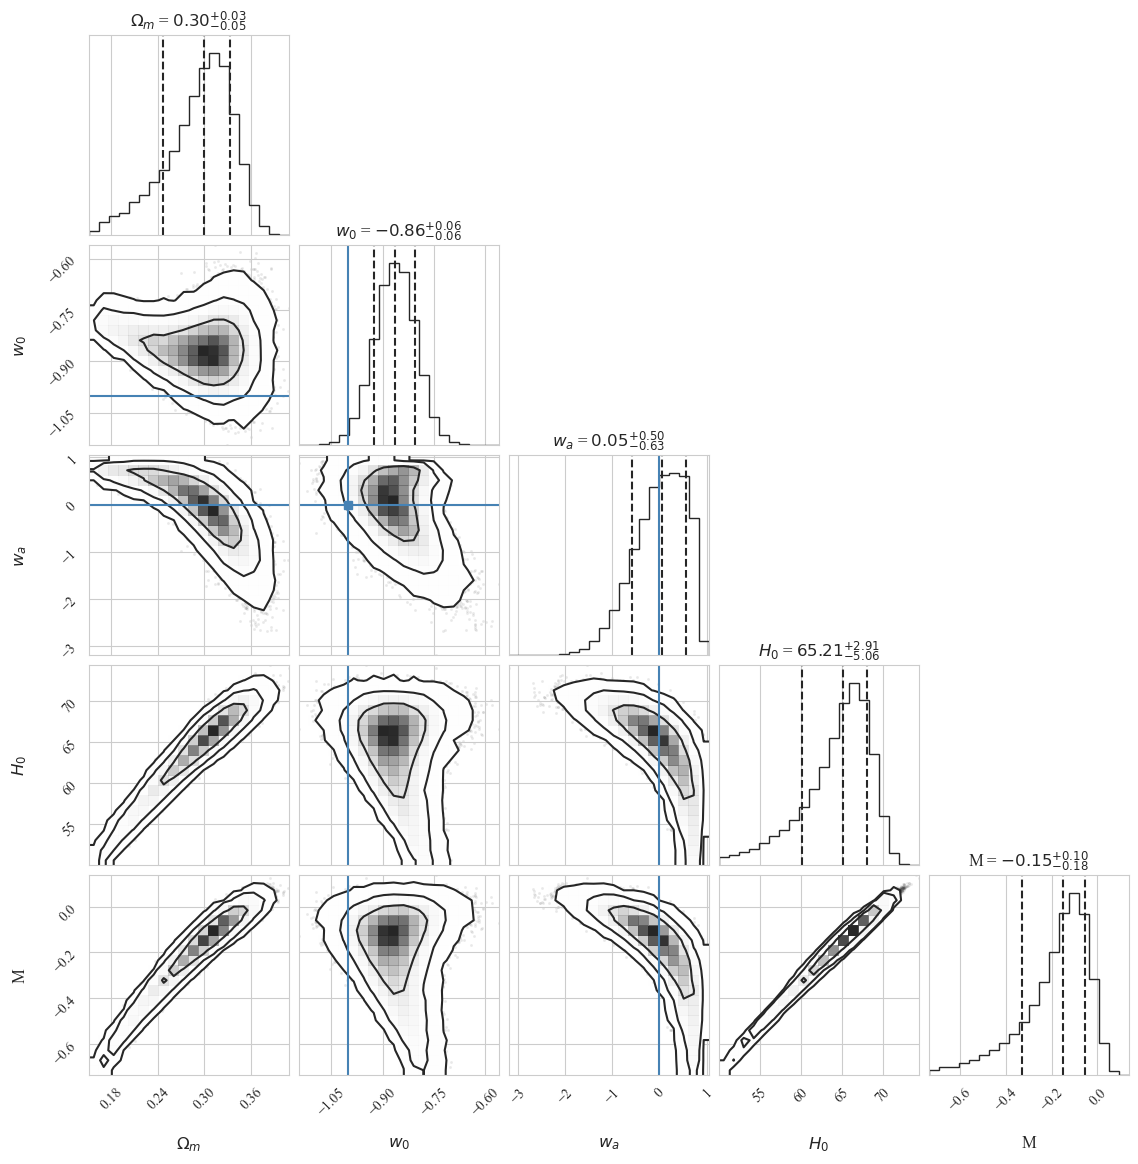

In [23]:
plt.rc('font', family='serif', serif='Times New Roman')

figure = corner.corner(samples_all_different_cosmo_with_H0_nocmb,
                       labels=[r"$\Omega_m$", r"$w_0$", r"$w_a$",r"$H_0$","M"],
                       show_titles=True,
                       title_kwargs={"fontsize": 12},
                       quantiles=[0.16, 0.5, 0.84],
                       truths=[np.nan,-1,0,np.nan,np.nan],
                       label_kwargs={"fontsize": 12},
                       plot_datapoints=True,
                       plot_density=True,
                       levels=(0.68, 0.95, 0.997))
plt.show()

In [24]:
samples_selectedwith_H0_nocmb = samples_all_different_cosmo_with_H0_nocmb[:, :4]
np.save('lcdm_BAO_SNe_differ_omm_all_marginh0.npy', samples_selectedwith_H0_nocmb)

In [25]:
from cmb_likelihood_cal_with_sne_cov_gaussian_ombh2 import run_mcmc_with_cmb
from cmb_likelihood_cal_with_sne_cov import la_rzs_from_cosmoparams as la_rzs_from_cosmoparams_true

dv_dr_lcdm30 = bao_dv_dr(zeff_array, H0=68.5, Om0=0.295, w0=-1.0, wa=0)
fap_lcdm30 = bao_fap(zeff_fap, H0=68.5, Om0=0.295, w0=-1.0, wa=0)

initial_guess_des = [0.35, -1, 0, 70,0]
z_all_different_cosmo = {'dv': zeff_array, 'fap': zeff_fap}
data_obs_all_different_cosmo = { 'dv': dv_dr_lcdm30, 'fap': fap_lcdm30}
data_err_all_different_cosmo = { 'dv': delta_dv, 'fap': delta_fap}

data_cmb = la_rzs_from_cosmoparams_true(H0=67.3, omegam=0.315, w=-1, wa=0.0)

samples_all_CMB_BAO_with_H0 = run_mcmc_with_cmb(z=z_all_different_cosmo, data_obs=data_obs_all_different_cosmo, data_err=data_err_all_different_cosmo,  data_obs_cmb=data_cmb, type='combined_distmod_with_H0', initial_guess=initial_guess_des, ndim=5, nwalkers=300, nsteps=8888, nburn=5333, nthin=15)

100%|██████████| 8888/8888 [09:47<00:00, 15.12it/s]


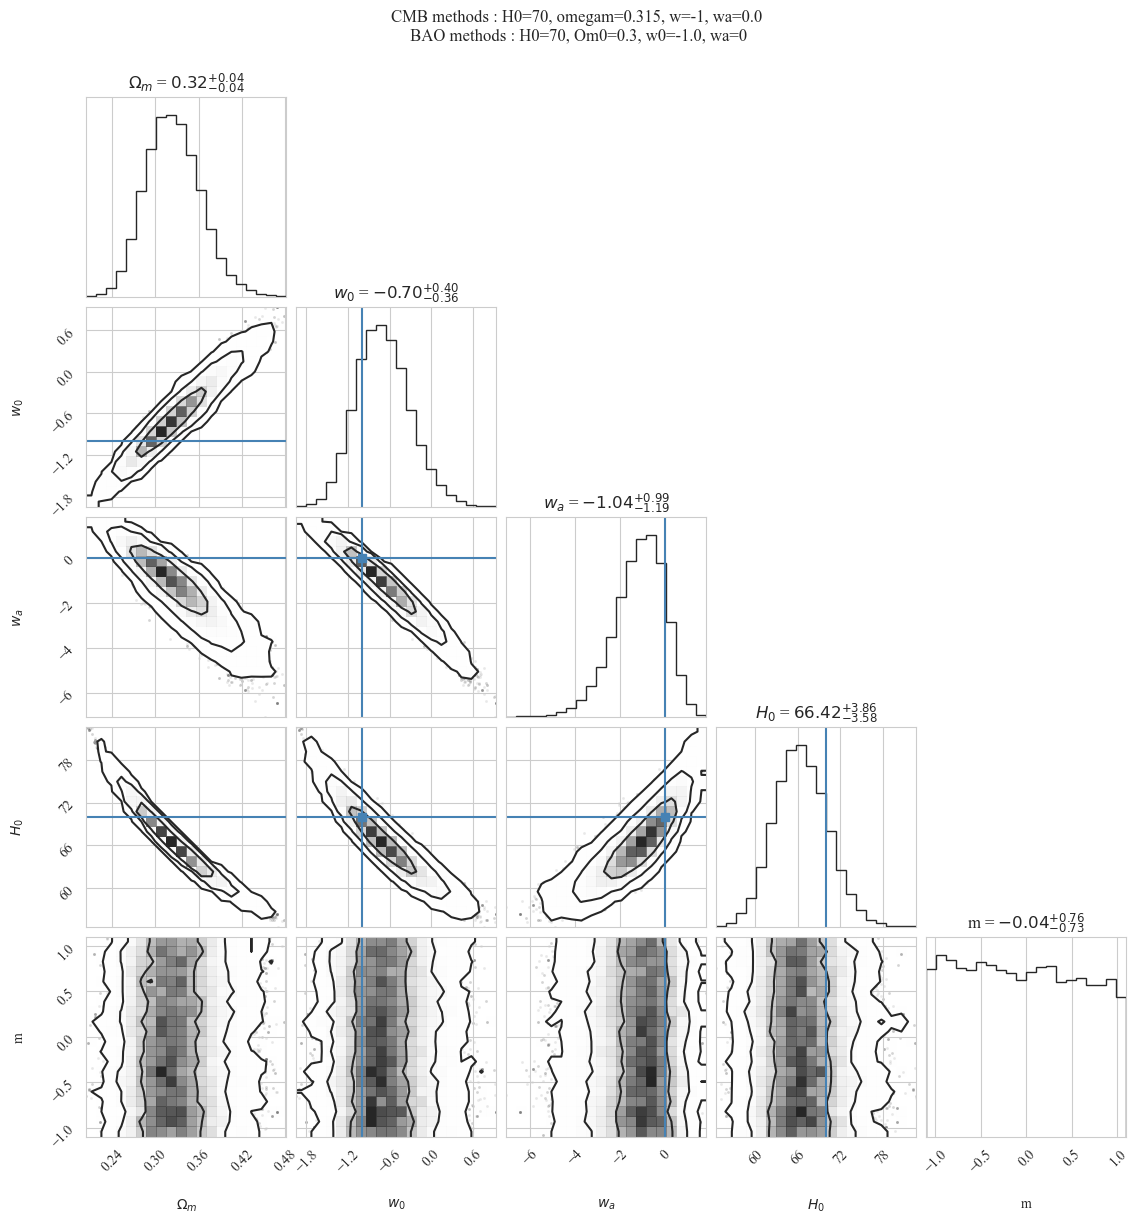

In [26]:
figure=corner.corner(samples_all_CMB_BAO_with_H0, labels=['$\Omega_m$', '$w_0$', '$w_a$', '$H_0$','m'], truths=[np.nan, -1, 0, 70,np.nan], show_titles=True,levels=(0.68, 0.95, 0.997))

figure.suptitle("CMB methods : H0=70, omegam=0.315, w=-1, wa=0.0\n BAO methods : H0=70, Om0=0.3, w0=-1.0, wa=0", fontsize=12, y=1.04)
plt.show()

In [27]:
samples_selected_2 = samples_all_CMB_BAO_with_H0[:, :4]
np.save('lcdm_CMB_BAO_differomm_all_marginh0.npy', samples_selected_2)

In [29]:
from cmb_likelihood_cal_with_sne_cov_gaussian_ombh2 import run_mcmc_with_cmb
from cmb_likelihood_cal_with_sne_cov import la_rzs_from_cosmoparams as la_rzs_from_cosmoparams_true
from wowadis_muilt_withcovmat_marginalH0 import sne_distmod
initial_guess_all_with_H0 = [0.3, -1, 0, 69,0]
dv_dr_lcdm30 = bao_dv_dr(zeff_array, H0=68.5, Om0=0.295, w0=-1.0, wa=0)
fap_lcdm30 = bao_fap(zeff_fap, H0=68.5, Om0=0.295, w0=-1.0, wa=0)

compare_cosmo_sne_35 = FlatLambdaCDM(H0=70, Om0=0.353)
des_distmod_compare_desy5_35 = sne_distmod(z=z_desy5, H0=70, Om0=0.353, w0=None, wa=None, cosmo=compare_cosmo_sne_35)
z_all_different_cosmo = {'sne': z_desy5, 'dv': zeff_array, 'fap': zeff_fap}
data_obs_all_different_cosmo = {'sne': des_distmod_compare_desy5_35, 'dv': dv_dr_lcdm30, 'fap': fap_lcdm30}
data_err_all_different_cosmo = {'sne': distmod_error_desy5, 'dv': delta_dv, 'fap': delta_fap}

data_cmb = la_rzs_from_cosmoparams_true(H0=67.3, omegam=0.315, w=-1, wa=0.0)

samples_all_different_cosmo_with_H0 = run_mcmc_with_cmb(z=z_all_different_cosmo, data_obs=data_obs_all_different_cosmo, data_err=data_err_all_different_cosmo,  data_obs_cmb=data_cmb, type='combined_distmod_with_H0', initial_guess=initial_guess_all_with_H0, ndim=5, nwalkers=250, nsteps=8888, nburn=4500, nthin=15)

100%|██████████| 8888/8888 [56:21<00:00,  2.63it/s]  


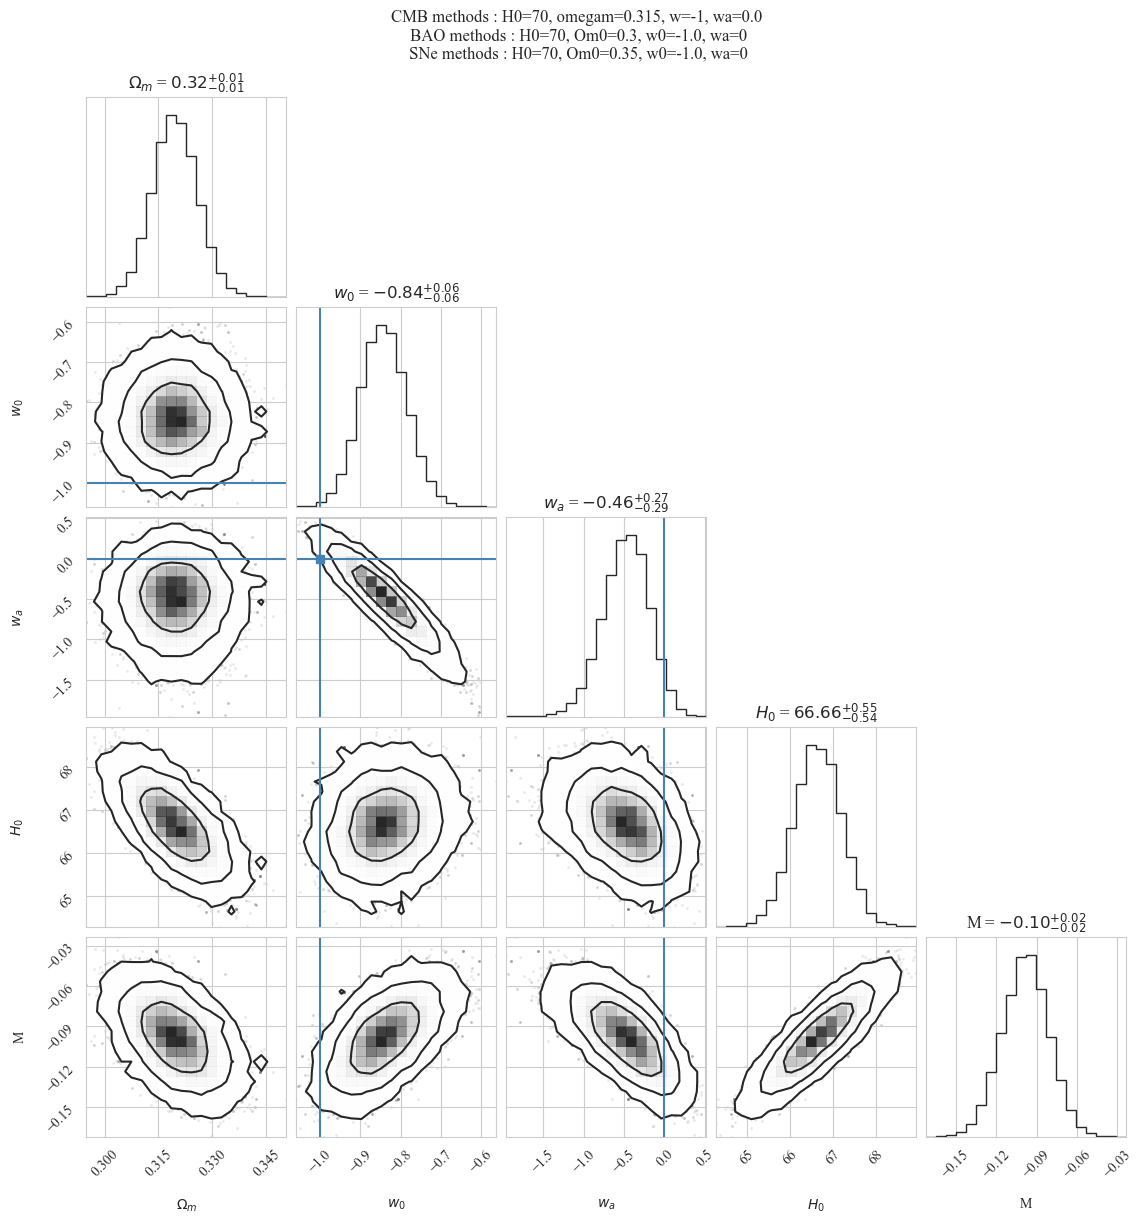

In [30]:
figure=corner.corner(samples_all_different_cosmo_with_H0, labels=['$\Omega_m$', '$w_0$', '$w_a$', '$H_0$','M'],  truths=[np.nan, -1, 0, 70,np.nan], show_titles=True,levels=(0.68, 0.95, 0.997))

figure.suptitle("CMB methods : H0=70, omegam=0.315, w=-1, wa=0.0\n BAO methods : H0=70, Om0=0.3, w0=-1.0, wa=0\n SNe methods : H0=70, Om0=0.35, w0=-1.0, wa=0", fontsize=12, y=1.04)
plt.show()

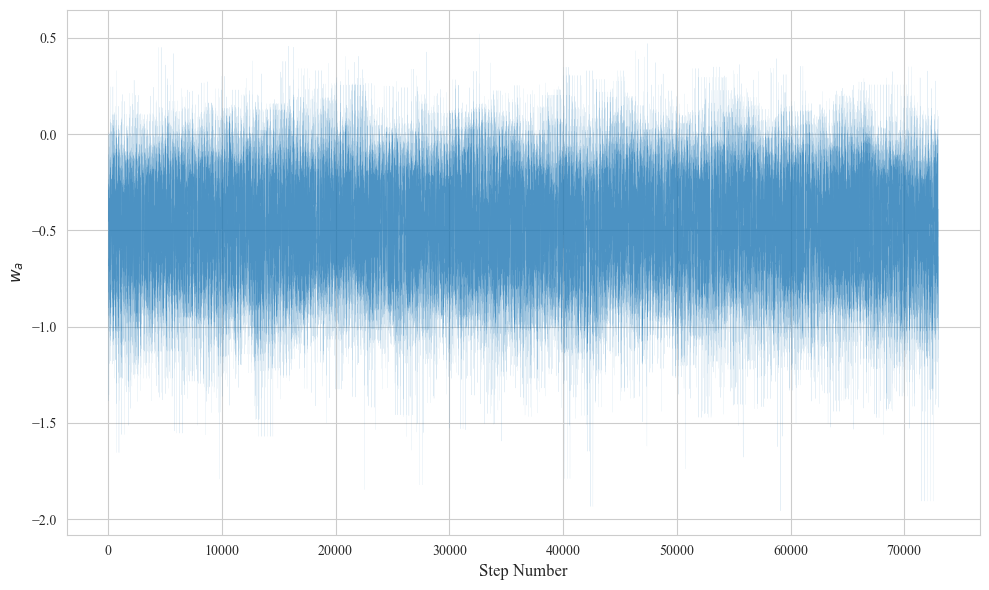

In [36]:
import matplotlib.pyplot as plt

#samples_selectedwith_H0_nocmb= np.load('lcdm_BAO_SNe_differ_omm_all_marginh0.npy')
#samples = np.array(samples_selectedwith_H0_nocmb)
samples=samples_all_different_cosmo_with_H0
#np.save('lcdm_BAO_SNe_differ_omm_all_marginh0.npy', samples_selectedwith_H0_nocmb)

wa_samples = samples[:, 2]  # Extract the wa column (index 2)

step_numbers = np.arange(len(wa_samples))

plt.figure(figsize=(10, 6))
plt.plot(step_numbers, wa_samples, alpha=0.8, lw=0.05)
#plt.title("Evolution of $w_a$ versus Step Number", fontsize=14)
plt.xlabel("Step Number", fontsize=12)
plt.ylabel("$w_a$", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

In [35]:
samples_all_different_cosmo_with_H0
np.save('lcdm_BAO_SNe_CMB_differ_omm_all_marginH.npy', samples_all_different_cosmo_with_H0)